<h1 style="color: #006400;">Data Imputations</h1>
<h3 style="color: #8b5e3c;">Filling in missing data using mean, median, and mode</h3>

<p style="color: #8b5e3c;">Mathias Galvan</p>
<h2 style="color: #006400;"> Loading the Data </h2>

In [2]:
import pandas as pd

account = pd.read_csv(r"C:/Users/galvanm/python/BucksHackathon25/BucksDatasets/AccountLevel.csv")
seat = pd.read_csv(r"C:/Users/galvanm/python/BucksHackathon25/BucksDatasets/SeatLevel.csv")
game = pd.read_csv(r"C:/Users/galvanm/python/BucksHackathon25/BucksDatasets/GameLevel.csv")

account['Season'].astype('category')
account['STM'].astype('category')
account.head()

,Season,AccountNumber,SingleGameTickets,PartialPlanTickets,GroupTickets,STM,AvgSpend,GamesAttended,FanSegment,DistanceToArena,BasketballPropensity,SocialMediaEngagement
0,2023,1,0,0,0,0,467.0,0,F,12.0,872.0,Low
1,2023,2,2,0,0,0,116.0,1,A,47.0,485.0,Low
2,2023,3,3,0,0,0,107.0,1,B,6.0,896.0,Low
3,2023,4,0,0,3,0,27.0,1,C,3.0,467.0,High
4,2023,5,0,0,2,0,14.0,1,A,4.0,582.0,Medium


<h3>Checking which features contain NaN</h3>

In [4]:

for i in account.columns:
    has_nans = account[i].isna().values.any()
    print(f"Nan in AccountLevel[{i}]: {has_nans}")

Nan in AccountLevel[Season]: False
Nan in AccountLevel[AccountNumber]: False
Nan in AccountLevel[SingleGameTickets]: False
Nan in AccountLevel[PartialPlanTickets]: False
Nan in AccountLevel[GroupTickets]: False
Nan in AccountLevel[STM]: False
Nan in AccountLevel[AvgSpend]: False
Nan in AccountLevel[GamesAttended]: False
Nan in AccountLevel[FanSegment]: False
Nan in AccountLevel[DistanceToArena]: True
Nan in AccountLevel[BasketballPropensity]: True
Nan in AccountLevel[SocialMediaEngagement]: False


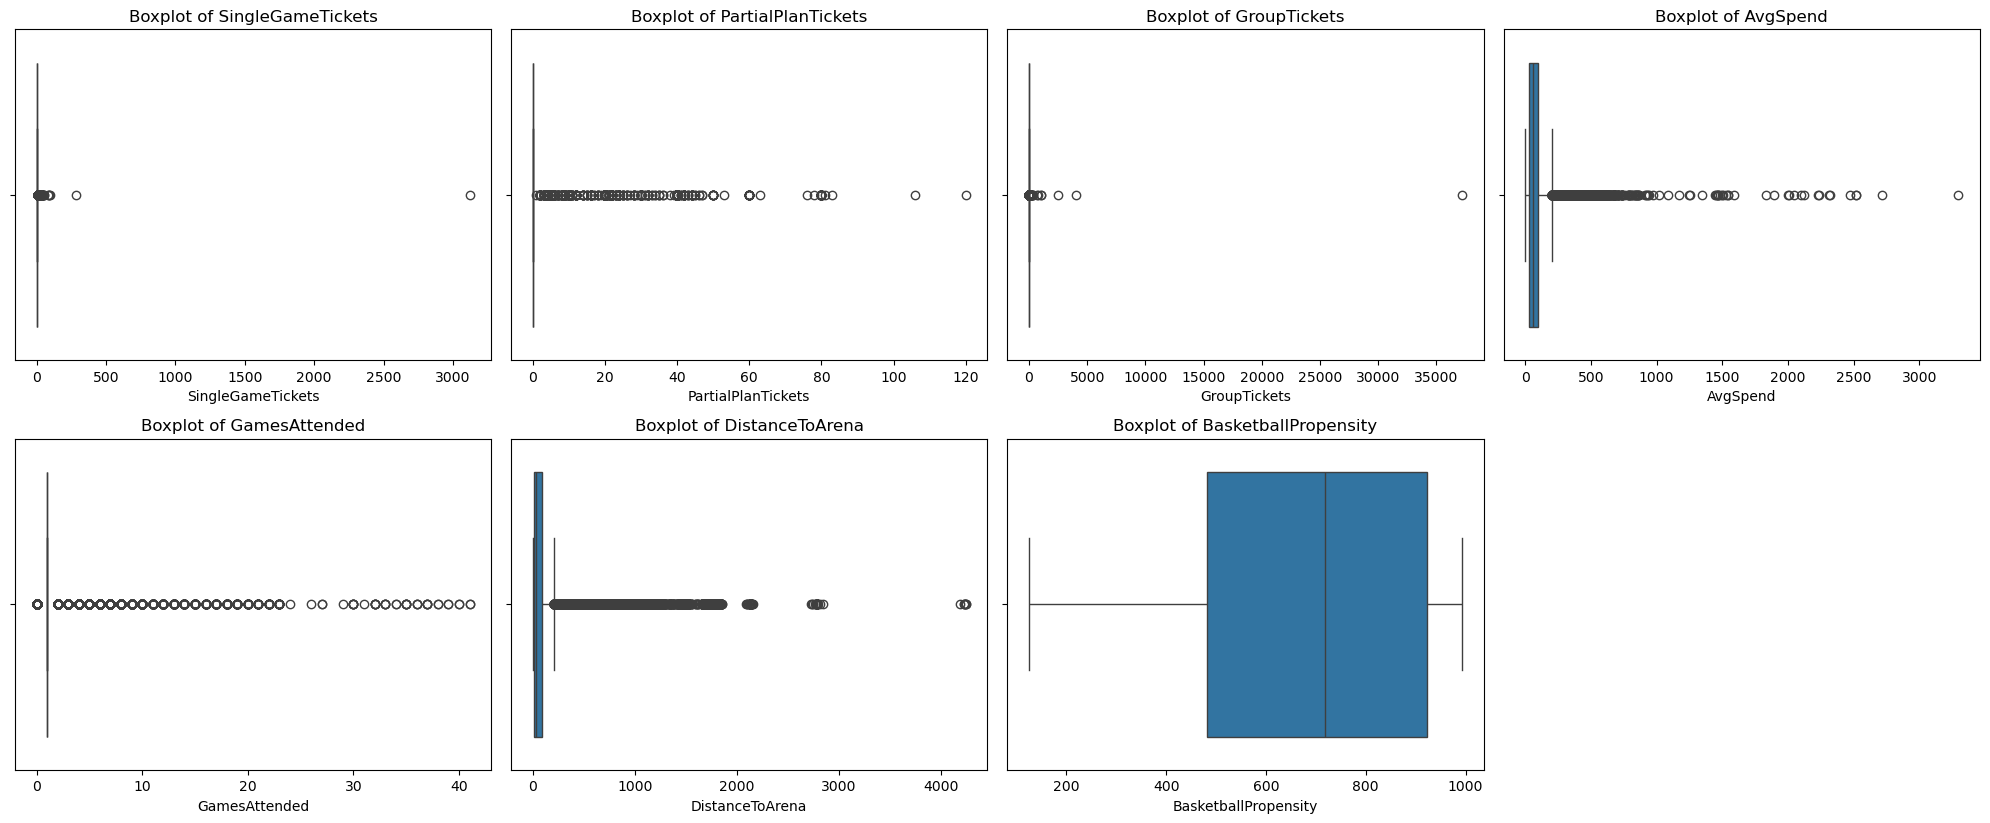

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['SingleGameTickets', 'PartialPlanTickets', 'GroupTickets', 'AvgSpend', 'GamesAttended', 'DistanceToArena', 'BasketballPropensity']
# setting the number of rows and columns
rows = 3
columns = 4

# creating the figure
fig, axes = plt.subplots(rows, columns, figsize=(20, 12)) 
axes = axes.flatten()

for ax, col in zip(axes, cols):
    #plt.figure(figsize=(6,4))
    sns.boxplot(x= account[col], ax=ax)
    ax.set_title(f'Boxplot of {col}')
    ax.set_xlabel(col)

for ax in axes[len(cols):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [6]:
import numpy as np

col_r_sampling = ['SingleGameTickets', 'PartialPlanTickets', 'GroupTickets', 'AvgSpend', 'GamesAttended', 'DistanceToArena']

nan_rows = account[account.isna().any(axis=1)]
print(nan_rows)

for i in col_r_sampling:
    non_missing = account[i].dropna().values
    account.loc[account[i].isna(), i] = np.random.choice(non_missing, size=account[i].isna().sum())

account.iloc[70]


       Season  AccountNumber  SingleGameTickets  PartialPlanTickets  \
8        2023              9                  0                   0   
17       2023             18                  4                   0   
70       2023             71                  0                   0   
131      2023            132                  1                   0   
133      2023            134                  2                   0   
...       ...            ...                ...                 ...   
43544    2024          42376                  0                   0   
43734    2024          42561                  0                   0   
43781    2024          42606                  0                   0   
43959    2024          42782                  0                   0   
44100    2024          42921                  0                   4   

       GroupTickets  STM  AvgSpend  GamesAttended    FanSegment  \
8                 2    0     24.50              1  Limited Data   
17           

Season                           2023
AccountNumber                      71
SingleGameTickets                   0
PartialPlanTickets                  0
GroupTickets                        2
STM                                 0
AvgSpend                        112.0
GamesAttended                       1
FanSegment               Limited Data
DistanceToArena                  22.0
BasketballPropensity              NaN
SocialMediaEngagement          Medium
Name: 70, dtype: object

In [7]:
median_bp = account['BasketballPropensity'].median()
account['BasketballPropensity'].fillna(median_bp, inplace=True)

for i in account.columns:
    has_nans = account[i].isna().values.any()
    print(f"Nan in AccountLevel[{i}]: {has_nans}")

Nan in AccountLevel[Season]: False
Nan in AccountLevel[AccountNumber]: False
Nan in AccountLevel[SingleGameTickets]: False
Nan in AccountLevel[PartialPlanTickets]: False
Nan in AccountLevel[GroupTickets]: False
Nan in AccountLevel[STM]: False
Nan in AccountLevel[AvgSpend]: False
Nan in AccountLevel[GamesAttended]: False
Nan in AccountLevel[FanSegment]: False
Nan in AccountLevel[DistanceToArena]: False
Nan in AccountLevel[BasketballPropensity]: False
Nan in AccountLevel[SocialMediaEngagement]: False


C:\Users\galvanm\AppData\Local\Temp\ipykernel_19860\2893900790.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  account['BasketballPropensity'].fillna(median_bp, inplace=True)


### Relabeling FanSegment using KNN

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

def impute_fan_segment(df):
    num_features = ['GamesAttended', 'DistanceToArena', 'BasketballPropensity', 'STM', 'AvgSpend']
    cat_features = ['SocialMediaEngagement']

    labeled = df['FanSegment'] != 'Limited Data'
    labeled_df = df[labeled].copy()
    unlabeled_df = df[~labeled].copy()

    X_train = labeled_df[num_features + cat_features]
    y_train = labeled_df['FanSegment']

    le = LabelEncoder()
    y_enc = le.fit_transform(y_train)

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

    pipeline = Pipeline([
        ('pre', preprocessor),
        ('knn', KNeighborsClassifier())
    ])

    pipeline.fit(X_train, y_enc)

    X_unlab = unlabeled_df[num_features + cat_features]
    y_pred = pipeline.predict(X_unlab)
    unlabeled_df['FanSegment'] = le.inverse_transform(y_pred)

    df_imputed = pd.concat([labeled_df, unlabeled_df]).sort_index()
    return df_imputed

In [10]:
account = impute_fan_segment(account)

### Adding Giveaway Labels (0 or 1)

In [12]:
def giveaway_label(x):
    if pd.isna(x):
        return 0
    else:
        return 1


In [13]:
game['GiveawayLabel'] = game['Giveaway'].apply(giveaway_label)

### Overwriting Datasets with Imputations

In [15]:
account.to_csv(r'/Users/galvanm/python/BucksHackathon25/BucksDatasets/AccountLevel.csv')
seat.to_csv(r'/Users/galvanm/python/BucksHackathon25/BucksDatasets/SeatLevel.csv')
game.to_csv(r'/Users/galvanm/python/BucksHackathon25/BucksDatasets/GameLevel.csv')
